In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

from scipy import stats

In [2]:
class RecurrentSpaceNet(torch.nn.Module):
    def __init__(self, n_in, n_out, scale = 0.4, device = "cpu", **kwargs):
        super().__init__(**kwargs)
        self.scale = scale
        self.device = device
        self.p0 = torch.nn.Sequential(
                torch.nn.Linear(2, 64),
                torch.nn.ReLU(),
                torch.nn.Linear(64, n_out),
                torch.nn.ReLU())

        self.spatial_representation = torch.nn.RNN(
            input_size = n_in,
            hidden_size = n_out,
            nonlinearity= "relu",
            bias=False,
            batch_first=True)        
        
        torch.nn.init.eye_(self.spatial_representation.weight_hh_l0) # identity initialization   
        self.to(device)
    
    def correlation_function(self, r):
        # Compare across time and samples
        rr = torch.reshape(r, (-1, 2)) # bs*ts, 2
        dr = torch.sum((rr[:,None] - rr[None])**2, dim = -1)
        correlation = torch.exp(-0.5/self.scale**2*dr) 
        return torch.triu(correlation, diagonal = 0) # save some computation
        
    def forward(self, inputs):
        # RNN returns representations and final hidden state
        initial_state = self.p0(inputs[1])
        p, _ = self.spatial_representation(inputs[0], initial_state[None])
        pcorr = torch.reshape(p, (-1, p.shape[-1])) # bsts, N
        corr = pcorr@torch.transpose(pcorr, dim0 = -1, dim1 = -2) # correlation matrix
        return torch.triu(corr, diagonal = 0)
    
    def train_step(self, x, y, optimizer):
        optimizer.zero_grad()
        loss = self.loss_fn(x, y)
        loss.backward()
        optimizer.step()
        return loss.item()
        
    def loss_fn(self, x, y):
        # x = inputs to model, y = labels
        corr = self(x)
        label_corr = self.correlation_function(y)
        loss = torch.mean((corr - label_corr)**2)
        return loss

In [3]:
# Simple test dataset maker; square box + bounce off walls

class DatasetMaker(object):
    def __init__(self, chamber_size = 1):
        self.chamber_size = chamber_size
        
    def bounce(self, r, v):
        outside = np.abs(r + v) >= self.chamber_size
        v[outside] = -v[outside]
        return v

    def generate_dataset(self, samples, timesteps, device = "cpu"):
        stddev = 4*np.pi # von Mises
        r = np.zeros((samples, timesteps, 2))

        s = np.random.rayleigh(0.025, (samples, timesteps))
        prev_hd = np.random.uniform(0, 2*np.pi, samples)
        r[:,0] = np.random.uniform(-self.chamber_size, self.chamber_size, (samples, 2)) 

        for i in range(timesteps - 1):
            hd = np.random.vonmises(prev_hd, stddev, samples)
            prop_v = s[:,i,None]*np.stack((np.cos(hd), np.sin(hd)),axis=-1)
            v = self.bounce(r[:,i], prop_v) 
            prev_hd = np.arctan2(v[:,1], v[:,0])
            r[:,i+1] = r[:,i] + v # dt = 1

        v = np.diff(r, axis = 1)
        
        return torch.tensor(r.astype('float32'), device = device), torch.tensor(v.astype('float32'), device = device)


In [4]:
## Training parameters
train_steps = 50000

n_in = 2 # Cartesian coordinates, no context
n_out = 100 # no. of spatial representations
timesteps = 10
bs = 32 # batch size

In [5]:
# instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in, n_out, scale = 0.3, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

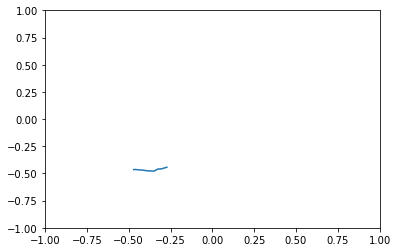

In [6]:
genny = DatasetMaker()
r, v = genny.generate_dataset(1, timesteps)
plt.plot(*r.detach().numpy().T)
plt.axis([-1, 1, -1, 1])
plt.show()

In [7]:
loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    r_label = r[:,1:]
    loss = model.train_step(x = (v, r[:,0]), y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000784: 100%|██████████| 50000/50000 [01:43<00:00, 480.79it/s]


Text(0, 0.5, 'Train Loss')

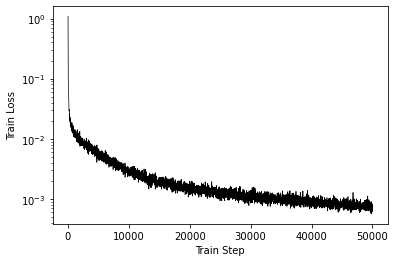

In [8]:
#loss_history = loss_history[1:]
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [9]:
r, v = genny.generate_dataset(5000, timesteps)
# inference
model.to("cpu")
p,_ = model.spatial_representation(v, model.p0(r[:,0])[None])
p = p.detach().numpy()

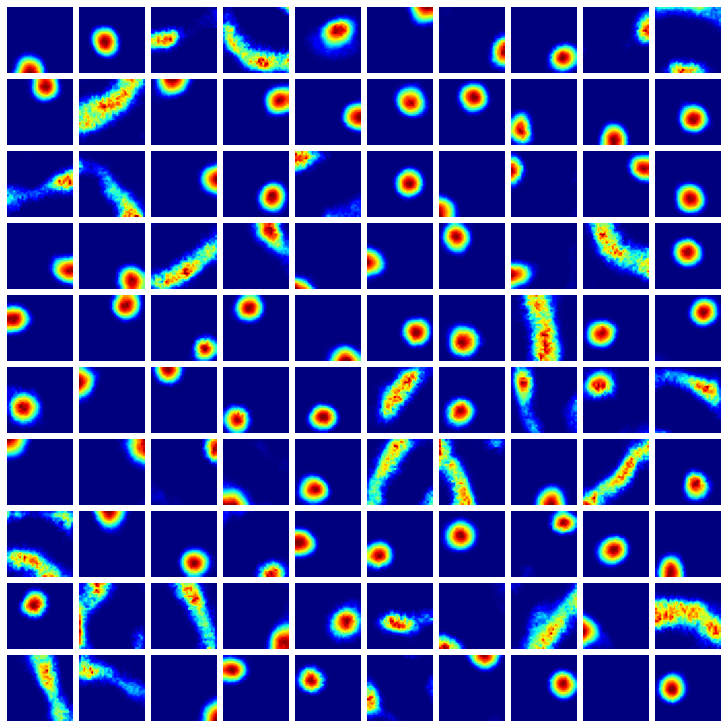

In [10]:

n_show = 10 # show all units in network

fig, ax = plt.subplots(n_show, n_show, figsize = (10,10), constrained_layout = True)

ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)

for i in range(n_show**2):
    ax[i//n_show, i%n_show].imshow(ratemaps[i].T, origin = "lower", cmap = "jet")
    ax[i//n_show, i%n_show].axis("off")

In [11]:
w = np.copy(model.spatial_representation.weight_hh_l0.detach().numpy())
#np.fill_diagonal(w, np.nan) # self-connection is typically large!

Text(0.5, 1.0, '$W_{out}$')

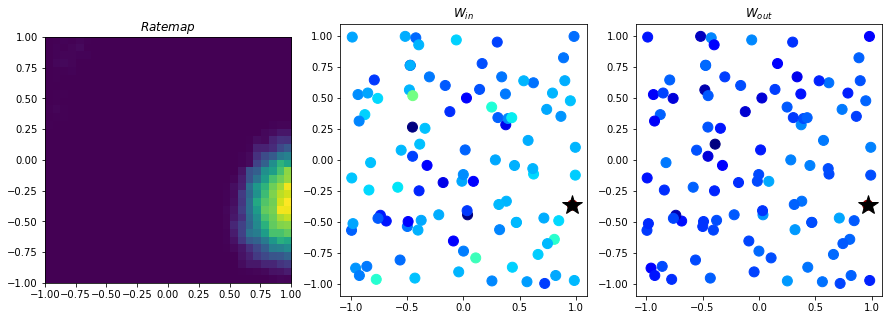

In [12]:
extent = [-genny.chamber_size, genny.chamber_size]*2
centers = rs[np.argmax(ps, axis = 0)]

unit = 6
cmap = "jet"
s = 100
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

ax[0].imshow(ratemaps[unit].T, origin = "lower", extent = extent)
ax[0].set_title("$Ratemap$")
ax[1].plot(centers[unit,0], centers[unit,1], "*k", markersize = 20)
ax[1].scatter(centers[:,0], centers[:,1], c = w[unit], s = s, cmap = cmap)
ax[1].set_title("$W_{in}$")
ax[2].plot(centers[unit,0], centers[unit,1], "*k", markersize = 20)
ax[2].scatter(centers[:,0], centers[:,1], c = w[:,unit], s = s, cmap = cmap)
ax[2].set_title("$W_{out}$")
#print(w[unit])

In [13]:
x = np.linspace(-1, 1, 32)
xx, yy = np.meshgrid(x,x)
rw = np.stack((xx.ravel(), yy.ravel()),axis = -1)

In [14]:
def weighted_kde(mu, w, bw = 1):
    # x.shape = N, 2
    # mu.shape = M, 2
    # w.shape = N
    # 1, M, 2 - N, 1, 2 --> N, M, 2
    # ---> N, M ---> N
    def kernel(x): 
        d = np.sum((mu[None] - x[:,None])**2,axis=-1)
        return np.sum(w*np.exp(-0.5/bw**2*d), axis = 1)
    return kernel

In [15]:
np.fill_diagonal(w, 0) # self-connection is typically large!


In [16]:
bw = 0.25
unit = 0
cmap = "bwr"

np.fill_diagonal(w, 0) # self-connection is typically large!

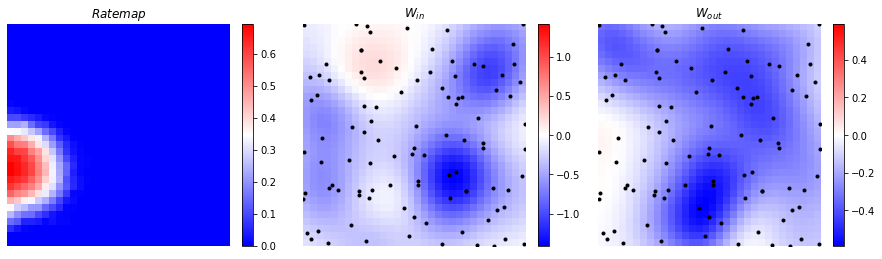

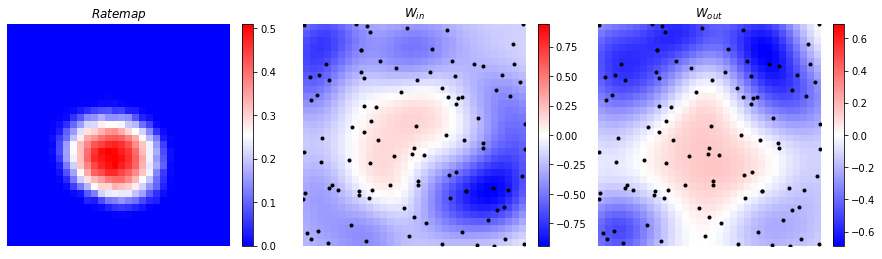

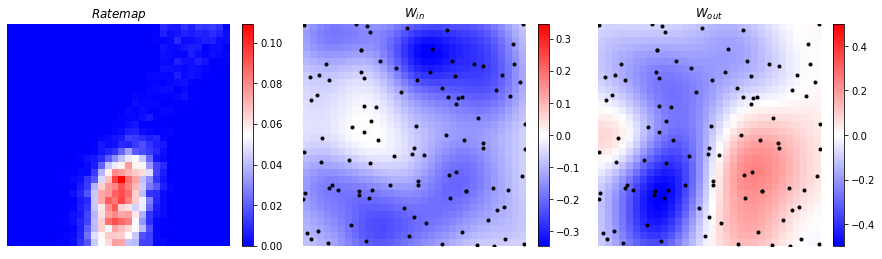

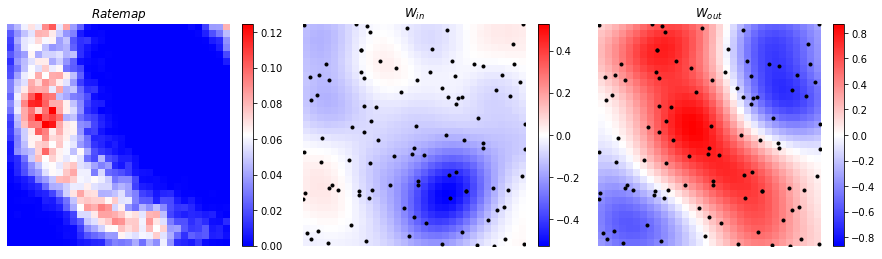

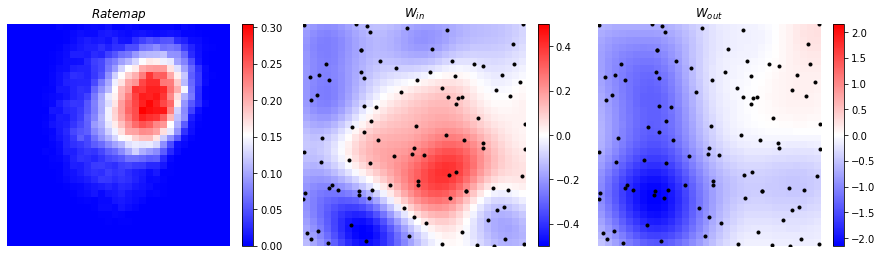

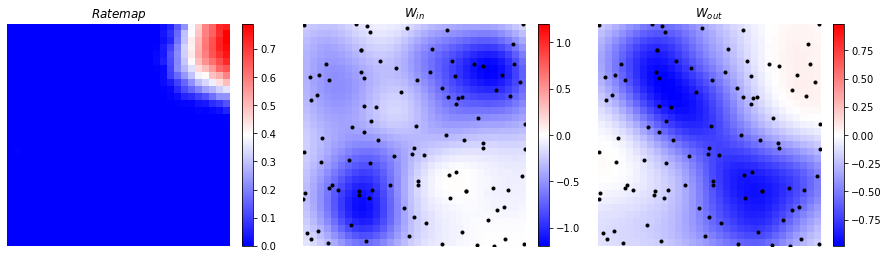

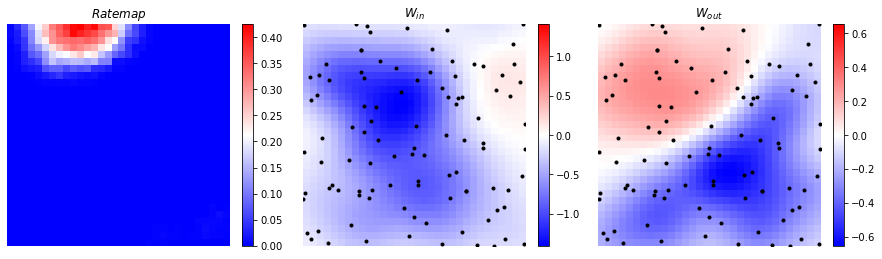

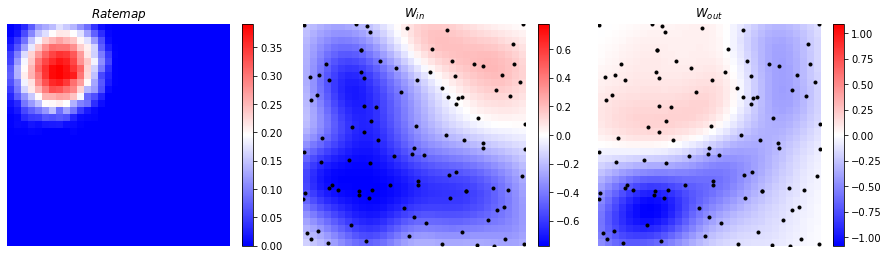

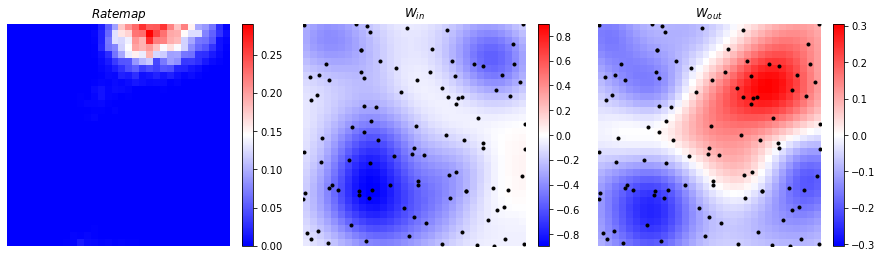

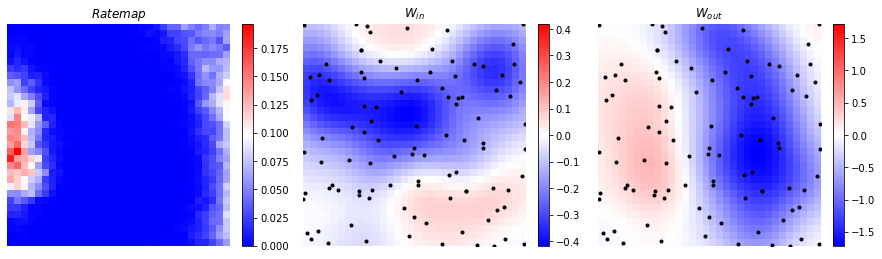

In [17]:
for unit in range(10):
    in_kernel = weighted_kde(centers, w[unit], bw = bw)
    in_kde = in_kernel(rw).reshape((32,32))

    out_kernel = weighted_kde(centers, w[:,unit], bw = bw)
    out_kde = out_kernel(rw)    

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))

    im0 = ax[0].imshow(ratemaps[unit], origin = "lower",
                       extent = extent, cmap = cmap)
    ax[0].set_title("$Ratemap$")
    fig.colorbar(im0, ax = ax[0], fraction = 0.045)


    vmax = np.amax(np.abs(in_kde))
    vmin = -vmax
    im1 = ax[1].imshow(in_kde, cmap = cmap,extent = extent,
                       vmin = vmin, vmax = vmax, origin = "upper")
    ax[1].plot(centers[:,0], centers[:,1],"k.")
    ax[1].set_title("$W_{in}$")
    fig.colorbar(im1, ax = ax[1], fraction = 0.045)

    vmax = np.amax(np.abs(out_kde))
    vmin = -vmax
    im2 = ax[2].imshow((out_kde.reshape(32,32)).T,cmap = cmap, extent = extent,
                      vmin = vmin, vmax = vmax, origin = "lower")
    ax[2].plot(centers[:,0], centers[:,1],"k.")
    ax[2].set_title("$W_{out}$")
    fig.colorbar(im2, ax = ax[2], fraction = 0.045)

    [axis.axis("off") for axis in ax]

In [18]:
max_inds = np.argmax(p, axis = -1)
pred = centers[max_inds]
beta = 10
pred_2 = np.sum(np.exp(beta*p[...,None])*centers[None,None], axis = -2)/np.sum(np.exp(beta*p) + 1e-16, axis = -1, keepdims = True)

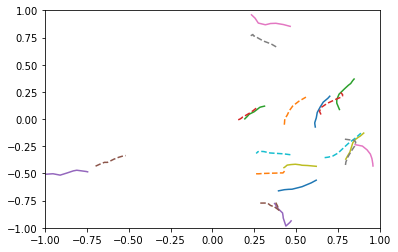

In [19]:
for i in range(10):
    plt.plot(*r[i,1:].T)
    plt.plot(*pred_2[i].T, "--")
    plt.axis([-1, 1, -1, 1])

In [20]:
res = r[:,1:] - pred_2
error = np.linalg.norm(res, axis = -1)

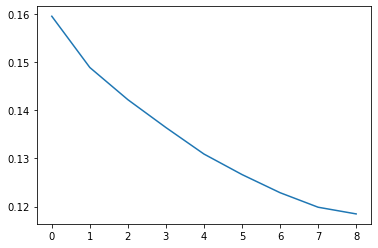

In [21]:
plt.plot(np.mean(error, axis = 0))

In [22]:
class Decoder(torch.nn.Module):
    def __init__(self, n_in, n_out = 2, **kwargs):
        
        super(Decoder, self).__init__(**kwargs)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(n_in, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, n_out))
        
        self.mse = torch.nn.MSELoss()
        
    def forward(self, x):
        return self.decoder(x)

    def train_step(self, x, y, optimizer):
        optimizer.zero_grad()
        loss = self.loss_fn(x, y)
        loss.backward()
        optimizer.step()
        return loss.item()
        
    def loss_fn(self, x, y):
        y_pred = self(x)
        return self.mse(y_pred, y)

In [23]:
decoder = Decoder(n_in = n_out, n_out = 2) # :o)
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)

In [24]:
loss_history = []

train_steps = 10000
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    p = model.spatial_representation(v, model.p0(r[:,0])[None])[0].detach()
    p = p.detach() 
    p = torch.reshape(p, (-1, p.shape[-1]))
    r_label = r[:,1:].reshape(-1, 2)
    loss = decoder.train_step(x = p, y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000142: 100%|██████████| 10000/10000 [00:12<00:00, 782.28it/s]


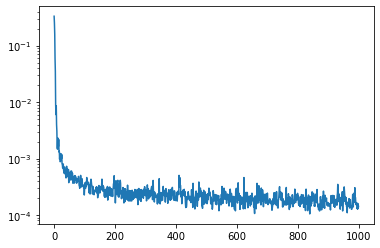

In [26]:
plt.semilogy(loss_history)

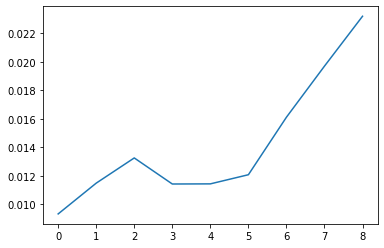

In [32]:
pred = decoder(p).detach().numpy()
error = np.linalg.norm(pred - r_label.detach().numpy(), axis = -1)
decoder_error = error.reshape(32, 9, -1)
plt.plot(np.mean(error, axis = 0))

In [47]:
class RecurrentNet(torch.nn.Module):
    def __init__(self, n_in, n_out = 2, **kwargs):
        super().__init__(**kwargs)
        self.device = device
        
        self.p0 = torch.nn.Sequential(
                torch.nn.Linear(n_in, 64),
                torch.nn.ReLU(),
                torch.nn.Linear(64, n_out),
                torch.nn.ReLU())

        self.spatial_representation = torch.nn.RNN(
            input_size = n_in,
            hidden_size = n_out,
            nonlinearity= "relu",
            bias=False,
            batch_first=True)        

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(n_out, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, n_in))    

        torch.nn.init.eye_(self.spatial_representation.weight_hh_l0) # identity initialization
        self.mse = torch.nn.MSELoss()
        
    def initial_state(self, input_shape):
        # random initial state
        s0 = torch.ones(size = (input_shape, 32), device = self.device)
        initial_state = self.p0(s0)
        return initial_state
    
    def forward(self, inputs):
        # RNN returns representations and final hidden state
        initial_state = self.p0(inputs[1])
        p, _ = self.spatial_representation(inputs[0], initial_state[None])
        return self.decoder(p)

    def train_step(self, x, y, optimizer):
        optimizer.zero_grad()
        loss = self.loss_fn(x, y)
        loss.backward()
        optimizer.step()
        return loss.item()
        
    def loss_fn(self, x, y):
        y_pred = self(x)
        return self.mse(y_pred, y)

In [48]:
recnet = RecurrentNet(n_in = n_in, n_out = n_out) # :o)
optimizer = torch.optim.Adam(recnet.parameters(), lr=1e-3)

In [49]:
loss_history = []

train_steps = 10000
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    loss = recnet.train_step(x = (v, r[:,0]), y = r[:,1:], optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000029: 100%|██████████| 10000/10000 [00:17<00:00, 569.25it/s]


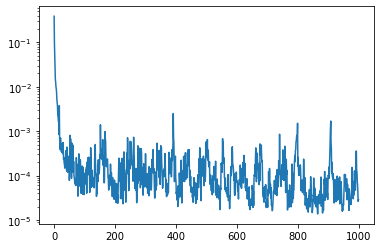

In [53]:
plt.semilogy(loss_history)

In [54]:
pred = recnet((v, r[:,0])).detach().numpy()
error = np.linalg.norm(pred - r_label.detach().numpy(), axis = -1)
recnet_error = error.reshape(32, 9, -1)
plt.plot(np.mean(recnet_error, axis = 0))

ValueError: operands could not be broadcast together with shapes (32,9,2) (288,2) 